In [1]:
import numpy as np
import random
import pandas as pd
from tqdm import tqdm
import torch
from torch_geometric.data import HeteroData, DataLoader
from torch_geometric.datasets import OGB_MAG
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
import torch_geometric.transforms as T
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, to_hetero, GATv2Conv

In [3]:
train_df = pd.read_csv('one2one_training.csv')
survival_df = pd.read_csv('survival_training.csv')
val_q_df = pd.read_csv("one2one_valid_query.csv")
val_a_df = pd.read_csv("one2one_valid_answer.csv")
val_df = pd.concat([val_q_df,val_a_df], axis=1)
val_df = val_df.loc[:, ~val_df.T.duplicated()]
test_df = pd.read_csv("one2one_test_query.csv")

In [4]:
len(train_df)

4982

### survival data에서 player마다 평균점수 구하기

In [4]:
# Initialize a dictionary to store the total scores and the number of games played for each player
player_scores = {}
player_games_played = {}

# Iterate through the rows of the DataFrame
for index, row in survival_df.iterrows():
    for i in range(8):
        player = row[f'player {i}']
        score = row[f'score {i}']
        if pd.notna(player) and pd.notna(score):
            player = int(player)
            player_scores[player] = player_scores.get(player, 0) + score
            player_games_played[player] = player_games_played.get(player, 0) + 1

# Calculate the average score for each player
player_avg_scores = {}
for player, total_score in player_scores.items():
    games_played = player_games_played[player]
    avg_score = total_score / games_played
    player_avg_scores[player] = avg_score

average_of_average_scores = sum(player_avg_scores.values()) / len(player_avg_scores)

### one2one data에서 이긴 횟수/참여한 횟수 count

In [5]:
# Initialize a dictionary to store the total counts and the number of games played for each player
player_counts = {}
one_player_games_played = {}

# Iterate through the rows of the DataFrame
def counts(df,player_counts,one_player_games_played):
  for index, row in df.iterrows():
      winner = row['winner']
      player1 = int(row['player 1'])
      player2 = int(row['player 2'])
      one_player_games_played[player1] = one_player_games_played.get(player1, 0) + 1
      one_player_games_played[player2] = one_player_games_played.get(player2, 0) + 1
    
      if winner == 'p1':
        player_counts[player1] = player_counts.get(player1, 0) + 1
      elif winner == 'p2':
        player_counts[player2] = player_counts.get(player2, 0) + 1
      elif winner == 'DRAW':
        player_counts[player1] = player_counts.get(player1, 0) + 0.5
        player_counts[player2] = player_counts.get(player2, 0) + 0.5
  return player_counts,one_player_games_played

player_counts,one_player_games_played = counts(train_df,player_counts,one_player_games_played)
player_counts,one_player_games_played = counts(val_df,player_counts,one_player_games_played)

# Calculate the average score for each player
player_avg_counts = {}
for player, total_score in player_counts.items():
    games_played = one_player_games_played[player]
    avg_score = total_score / games_played
    player_avg_counts[player] = avg_score

average_of_average_counts = sum(player_avg_counts.values()) / len(player_avg_counts)

### pagerank 점수 구하기 (사용 안함)

In [7]:
G = nx.DiGraph()
for g in tqdm(range(len(train_df))):
  game = train_df.iloc[g, 2:]
  p1_id = game['player 1']
  p2_id = game['player 2']
  winner = game['winner']
  if winner == 'p1':
    if G.has_edge(p2_id, p1_id):
      G[p2_id][p1_id]['weight'] += 1
    else :
      G.add_edge(p2_id,p1_id ,weight = 1)
  if winner == 'p2' :
    if G.has_edge(p1_id, p2_id):
      G[p1_id][p2_id]['weight'] += 1
    else :
      G.add_edge(p1_id,p2_id ,weight = 1)
  else :
    if G.has_edge(p1_id, p2_id):
      G[p1_id][p2_id]['weight'] += 0.5
    else :
      G.add_edge(p1_id,p2_id ,weight = 0.5)
    if G.has_edge(p1_id, p2_id):
      G[p1_id][p2_id]['weight'] += 0.5
    else :
      G.add_edge(p1_id,p2_id ,weight = 0.5)

page_rank = nx.pagerank(G, max_iter = 100, weight = 'weight')

# Calculate the average score for each player
average_of_pagerank = sum(page_rank.values()) / len(page_rank)

100%|█████████████████████████████████████████████████████████████████████████████| 4982/4982 [00:00<00:00, 9251.93it/s]


### 데이터 만들기

In [6]:
### (game1, player1), (game1, player2) 게임마다 노드 2개로 만들어보기

values = pd.DataFrame(list(player_avg_scores.values())).std()

player_idx = sorted(list(set(train_df['player 1'].values.tolist() + train_df['player 2'].values.tolist() + val_df['player 1'].values.tolist() + val_df['player 2'].values.tolist() + test_df['player 1'].values.tolist() + test_df['player 2'].values.tolist())))
player = [[(player_avg_scores.get(x,average_of_average_scores)-average_of_average_scores)/values[0],player_avg_counts.get(x,average_of_average_counts)] for x in player_idx]
# pagerank 점수 추가할 때는 아래 코드
#player = [[(player_avg_scores.get(x,average_of_average_scores)-average_of_average_scores)/values[0],player_avg_counts.get(x,average_of_average_counts),page_rank.get(x,average_of_pagerank)] for x in player_idx]

game_idx = train_df['game'].values.tolist() + val_df['game'].values.tolist() + test_df['game'].values.tolist()


edge_source = []
edge_destination = []
game_edge_source = []
game_edge_destination = []
player_edge_source = []
player_edge_destination = []
edge_attribute = []
game_y = []

# train set에서
for index, row in train_df.iterrows():
  p1_index = player_idx.index(row['player 1'])
  p2_index = player_idx.index(row['player 2'])
  game = game_idx.index(row['game'])
  winner = row['winner']

  edge_source.append(p1_index)
  edge_destination.append(2*game)
  edge_source.append(p2_index)
  edge_destination.append(2*game+1)
  game_edge_source.append(2*game)
  game_edge_destination.append(2*game+1)
  player_edge_source.append(p1_index)
  player_edge_destination.append(p2_index)

  if winner == 'p1':
    game_y.append([1,0,0])
    game_y.append([0,0,1])
  elif winner == 'p2':
    game_y.append([0,0,1])
    game_y.append([1,0,0])
  elif winner == 'DRAW':
    game_y.append([0,1,0])
    game_y.append([0,1,0])

# validation set에서
for index, row in val_df.iterrows():
  p1_index = player_idx.index(row['player 1'])
  p2_index = player_idx.index(row['player 2'])
  game = game_idx.index(row['game'])
  winner = row['winner']

  edge_source.append(p1_index)
  edge_destination.append(2*game)
  edge_source.append(p2_index)
  edge_destination.append(2*game+1)
  game_edge_source.append(2*game)
  game_edge_destination.append(2*game+1)
  player_edge_source.append(p1_index)
  player_edge_destination.append(p2_index)

  if winner == 'p1':
    game_y.append([1,0,0])
    game_y.append([0,0,1])
  elif winner == 'p2':
    game_y.append([0,0,1])
    game_y.append([1,0,0])
  elif winner == 'DRAW':
    game_y.append([0,1,0])
    game_y.append([0,1,0])

# test set에서
for index, row in test_df.iterrows():
  p1_index = player_idx.index(row['player 1'])
  p2_index = player_idx.index(row['player 2'])
  game = game_idx.index(row['game'])

  edge_source.append(p1_index)
  edge_destination.append(2*game)
  edge_source.append(p2_index)
  edge_destination.append(2*game+1)
  game_edge_source.append(2*game)
  game_edge_destination.append(2*game+1)
  player_edge_source.append(p1_index)
  player_edge_destination.append(p2_index)

  game_y.append([0,0,0]) # 임의의 값
  game_y.append([0,0,0])

c_date_df = pd.concat([train_df['date'],val_df['date']])
c_date_df = pd.concat([c_date_df, test_df['date']])
date_df = (c_date_df-c_date_df.min())/(c_date_df.max()-c_date_df.min()) # normalization
# date_mean = date_df.mean()
# date_std = date_df.std()
# date_df = (date_df - date_mean)/date_std # standardization

game_x = [[0] for x in range(2*len(date_df))]
# date 정보 추가할 시 아래 코드
#game_x = [[x] for x in date_df.repeat(2).reset_index(drop=True).values.tolist()]

In [7]:
# data 정의
data = HeteroData()
data['game'].x = torch.tensor(game_x).type(torch.float)
data['player'].x = torch.tensor(player).type(torch.float) # feature: player_average_score

data['game'].y = torch.tensor(game_y).type(torch.float)

data['player','participates','game'].edge_index = torch.tensor([edge_source,edge_destination])
#data['player','participates','game'].edge_attr = torch.tensor(edge_attribute) # first feature: player_num (1 or 2) / second feature: winner (2 for win, 1 for draw, 0 for loose)
data['game','same with','game'].edge_index = torch.tensor([game_edge_source,game_edge_destination])
data['player','fights with','player'].edge_index = torch.tensor([player_edge_source,player_edge_destination])
data = T.ToUndirected()(data)

data['game'].train_mask = torch.zeros(data['game'].num_nodes, dtype=torch.bool)
data['game'].train_mask[:2*len(train_df)] = 1 # game node 2개로 할 때는 곱하기 2 해줌 / train set일 경우 1로 해줌
data['game'].val_mask = torch.zeros(data['game'].num_nodes, dtype=torch.bool)
data['game'].val_mask[2*len(train_df):2*len(train_df)+2*len(val_df)] = 1
data['game'].test_mask = torch.zeros(data['game'].num_nodes, dtype=torch.bool)
data['game'].test_mask[2*len(train_df)+2*len(val_df):] = 1
data = data.cuda()
data

/data/anaconda/anaconda3/lib/python3.9/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


HeteroData(
  game={
    x=[12346, 1],
    y=[12346, 3],
    train_mask=[12346],
    val_mask=[12346],
    test_mask=[12346]
  },
  player={ x=[1672, 2] },
  (player, participates, game)={ edge_index=[2, 12346] },
  (game, same with, game)={ edge_index=[2, 12346] },
  (player, fights with, player)={ edge_index=[2, 10704] },
  (game, rev_participates, player)={ edge_index=[2, 12346] }
)

## 모델 만들기

In [8]:
class GNN(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), 64)
        self.conv2 = SAGEConv((-1, -1), 128)
        self.conv3 = SAGEConv((-1, -1), 256)
#         self.conv4 = SAGEConv((-1, -1), 512)
#         self.conv5 = SAGEConv((-1, -1), 1024)
        self.linear = torch.nn.Linear(256, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
#         x = self.conv3(x, edge_index).relu()
#         x = self.conv4(x, edge_index).relu()
        x = self.conv3(x, edge_index)
        x = self.linear(x)
        return x


model = GNN(out_channels=3)
model = to_hetero(model, data.metadata(), aggr='sum')
model = model.cuda()

/data/anaconda/anaconda3/lib/python3.9/site-packages/torch_geometric/nn/to_hetero_transformer.py:165: UserWarning: The type 'same with' contains invalid characters which may lead to unexpected behavior. To avoid any issues, ensure that your types only contain letters, numbers and underscores.
  warnings.warn(
/data/anaconda/anaconda3/lib/python3.9/site-packages/torch_geometric/nn/to_hetero_transformer.py:165: UserWarning: The type 'fights with' contains invalid characters which may lead to unexpected behavior. To avoid any issues, ensure that your types only contain letters, numbers and underscores.
  warnings.warn(


In [9]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#data, model = data.to(device), model.to(device)

In [10]:
import time
import copy

losses = []
training_accuracies = []
validation_accuracies = []

def test(mask):
  model.eval()
  pred = model(data.x_dict, data.edge_index_dict)['game'].argmax(dim=-1)[mask].tolist()
  answer= data['game'].y.argmax(dim=-1)[mask].tolist()
  score = 0
  for i in range(int(len(pred)/2)):
    a = answer[2*i:2*(i+1)]
    r = pred[2*i:2*(i+1)]
    if r[0] < r[1]:
        result = [0,2]
    elif r[0] > r[1]:
        result = [2,0]
    elif r[0] == r[1]:
        result = [1,1]
        
    if a == result:
        score += 1
    elif (a == [1,1]) or (result == [1,1]):
        score += 0.5

  acc = score*100/(int(len(pred)/2))
  #acc = (pred == data['game'].y.argmax(dim=-1)).sum() / data['game'].y.size()[0]
  return float(acc)

def train_model(model, num_epochs=500):
    """
    model: model to train
    dataloaders: train, val, test data's loader
    criterion: loss function
    optimizer: optimizer to update your model
    """
    since = time.time()
    max_val_acc = 0
    max_val_epoch = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        model.train()            # Set model to training mode

        optimizer.zero_grad()

        out = model(data.x_dict, data.edge_index_dict)
        mask = data['game'].train_mask
        loss = F.cross_entropy(out['game'][mask], data['game'].y[mask])

        loss.backward()
        optimizer.step()

        train_acc = test(data['game'].train_mask)
        val_acc = test(data['game'].val_mask)
        if val_acc > max_val_acc:
          max_val_acc = val_acc
          max_val_epoch = epoch
          torch.save(model, 'winner_best_model.pt')

        losses.append(loss)
        training_accuracies.append(train_acc)
        validation_accuracies.append(val_acc)

        print('Loss: {:.4f}'.format(float(loss)))
        print('Train Accuracy: {:.4f}'.format(float(train_acc)))
        print('Validation Accuracy: {:.4f}'.format(float(val_acc)))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('best_val_acc: '+str(max_val_acc)+' at epoch: '+str(max_val_epoch))
    #torch.save(model, "/content/drive/MyDrive/graph_mining/" + 'model.pt')



In [11]:
train_model(model)

Epoch 0/499
----------
Loss: 1.1300
Train Accuracy: 66.3890
Validation Accuracy: 61.8780

Epoch 1/499
----------
Loss: 0.9872
Train Accuracy: 69.5905
Validation Accuracy: 67.0947

Epoch 2/499
----------
Loss: 0.9950
Train Accuracy: 70.8952
Validation Accuracy: 65.8909

Epoch 3/499
----------
Loss: 0.9463
Train Accuracy: 71.7182
Validation Accuracy: 66.9342

Epoch 4/499
----------
Loss: 0.8848
Train Accuracy: 72.4910
Validation Accuracy: 70.8668

Epoch 5/499
----------
Loss: 0.8343
Train Accuracy: 72.8523
Validation Accuracy: 71.4286

Epoch 6/499
----------
Loss: 0.8242
Train Accuracy: 73.4143
Validation Accuracy: 72.0706

Epoch 7/499
----------
Loss: 0.8374
Train Accuracy: 73.8458
Validation Accuracy: 72.2311

Epoch 8/499
----------
Loss: 0.8392
Train Accuracy: 74.1068
Validation Accuracy: 73.2745

Epoch 9/499
----------
Loss: 0.8203
Train Accuracy: 74.6788
Validation Accuracy: 73.7560

Epoch 10/499
----------
Loss: 0.7992
Train Accuracy: 75.2007
Validation Accuracy: 73.2745

Epoch 11/

In [151]:
losses = [x.cpu().detach() for x in losses]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


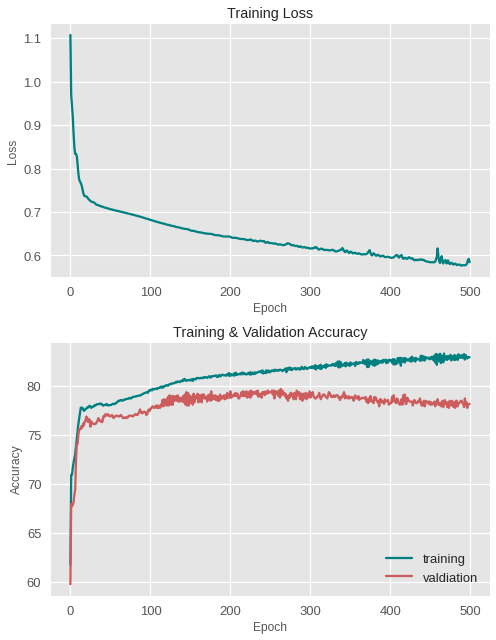

In [152]:
# Create a figure with three subplots
plt.figure(figsize=(7, 9))
plt.style.use('ggplot')

# Loss plot
plt.subplot(2, 1, 1)
plt.plot(losses, color='teal')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Training accuracy plot
plt.subplot(2, 1, 2)
plt.plot(training_accuracies,label = 'training', color='teal')
plt.plot(validation_accuracies, label = 'valdiation', color='indianred')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

## test data 결과 csv로 저장하기

In [154]:
# 모델 불러오기
model = torch.load("winner_best_model_79.6.pt")
model.eval()

GraphModule(
  (conv1): Module(
    (player__participates__game): SAGEConv((-1, -1), 64, aggr=mean)
    (game__same_with__game): SAGEConv((-1, -1), 64, aggr=mean)
    (player__fights_with__player): SAGEConv((-1, -1), 64, aggr=mean)
    (game__rev_participates__player): SAGEConv((-1, -1), 64, aggr=mean)
  )
  (conv2): Module(
    (player__participates__game): SAGEConv((-1, -1), 128, aggr=mean)
    (game__same_with__game): SAGEConv((-1, -1), 128, aggr=mean)
    (player__fights_with__player): SAGEConv((-1, -1), 128, aggr=mean)
    (game__rev_participates__player): SAGEConv((-1, -1), 128, aggr=mean)
  )
  (conv3): Module(
    (player__participates__game): SAGEConv((-1, -1), 256, aggr=mean)
    (game__same_with__game): SAGEConv((-1, -1), 256, aggr=mean)
    (player__fights_with__player): SAGEConv((-1, -1), 256, aggr=mean)
    (game__rev_participates__player): SAGEConv((-1, -1), 256, aggr=mean)
  )
  (linear): Module(
    (game): Linear(in_features=256, out_features=3, bias=True)
    (player

In [155]:
with torch.no_grad():
    pred = model(data.x_dict, data.edge_index_dict)['game'].argmax(dim=-1)[data['game'].test_mask].tolist()
pred_list = []
for i in range(int(len(pred)/2)):
    r = pred[2*i:2*(i+1)]
    if r[0] < r[1]:
        pred_list.append("p1")
    elif r[0] > r[1]:
        pred_list.append("p2")
    elif r[0] == r[1]:
        pred_list.append("DRAW")
pred_list

['p2',
 'p1',
 'p2',
 'p2',
 'p1',
 'p1',
 'p1',
 'p1',
 'p2',
 'p1',
 'p2',
 'p2',
 'DRAW',
 'DRAW',
 'p2',
 'p1',
 'p2',
 'p1',
 'p1',
 'p1',
 'p1',
 'p2',
 'p1',
 'p2',
 'p1',
 'p1',
 'p1',
 'p1',
 'p1',
 'DRAW',
 'p1',
 'p2',
 'p1',
 'p2',
 'p1',
 'p2',
 'p2',
 'p2',
 'p2',
 'p1',
 'p2',
 'p2',
 'p2',
 'p2',
 'p1',
 'p2',
 'p2',
 'p2',
 'DRAW',
 'p2',
 'p2',
 'p2',
 'p1',
 'p2',
 'p1',
 'p2',
 'p1',
 'p1',
 'p1',
 'p2',
 'p2',
 'p2',
 'p2',
 'p1',
 'p1',
 'p1',
 'p1',
 'p1',
 'p1',
 'p2',
 'p2',
 'p2',
 'p2',
 'p1',
 'p1',
 'p1',
 'p2',
 'p2',
 'DRAW',
 'p1',
 'p2',
 'p2',
 'p2',
 'p1',
 'p1',
 'p1',
 'p2',
 'p1',
 'p2',
 'p1',
 'DRAW',
 'p1',
 'p1',
 'DRAW',
 'p1',
 'p2',
 'p2',
 'p2',
 'DRAW',
 'p1',
 'p1',
 'p1',
 'p2',
 'p1',
 'p2',
 'DRAW',
 'p1',
 'DRAW',
 'p2',
 'p1',
 'p2',
 'p1',
 'p1',
 'p1',
 'p1',
 'p1',
 'p2',
 'DRAW',
 'p1',
 'p1',
 'p2',
 'p2',
 'p2',
 'p1',
 'p2',
 'p2',
 'p1',
 'p2',
 'p2',
 'DRAW',
 'DRAW',
 'p1',
 'p1',
 'DRAW',
 'p2',
 'p2',
 'DRAW',
 'p1',
 'p2

In [156]:
pred_df = pd.DataFrame(pred_list, columns=['winner'])
pred_df = pd.concat([test_df['game'], pred_df], axis=1)
pred_df

,game,winner
0,5605,p2
1,5606,p1
2,5607,p2
3,5608,p2
4,5609,p1
...,...,...
563,6222,p2
564,6223,p2
565,6224,p2
566,6225,DRAW


In [157]:
pred_df.to_csv("one2one_test_answer.csv", index = False)